In [2]:
import sklearn
from sklearn import svm, preprocessing, cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel 
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.learning_curve import learning_curve
import random
import numpy as np
import gensim
import csv
import numpy as np
import pandas as pd
import timeit
import nltk
import itertools
import glove
from collections import defaultdict
import pandas as pd
from nltk.stem import *
from nltk import word_tokenize, ngrams
import re
from gensim import corpora
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#### Loading Stopwords

In [3]:
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pascalsitbon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Loading Training Set

In [4]:
Training_Set = pd.read_csv('train.csv').dropna()

In [5]:
print(Training_Set.shape)

(404288, 6)


In [6]:
print(Training_Set.iloc[10,:]['question1'])

Method to find separation of slits using fresnel biprism?


In [7]:
clean_data = Training_Set[['question1','question2','is_duplicate']].values

In [8]:
sentences_train = clean_data[:,:2]
labels = clean_data[:,2]

In [11]:
for i in range(20):
    print('sample of data','\n',sentences_train[i,:],labels[i])

sample of data 
 ['What is the step by step guide to invest in share market in india?'
 'What is the step by step guide to invest in share market?'] 0
sample of data 
 ['What is the story of Kohinoor (Koh-i-Noor) Diamond?'
 'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?'] 0
sample of data 
 [ 'How can I increase the speed of my internet connection while using a VPN?'
 'How can Internet speed be increased by hacking through DNS?'] 0
sample of data 
 ['Why am I mentally very lonely? How can I solve it?'
 'Find the remainder when [math]23^{24}[/math] is divided by 24,23?'] 0
sample of data 
 [ 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?'
 'Which fish would survive in salt water?'] 0
sample of data 
 [ 'Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?'
 "I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?"] 1
sample of data 
 ['Should I b

In [426]:
size_train = 100000

## Word2vec featuring

In [427]:
def preprocess(sentence_train):
    sentences = []
    stemmer = PorterStemmer()
    for i in range(sentence_train.shape[0]): 
        source_sentence = sentences_train[i,0].lower().split(" ") 
        source_sentence = [token for token in source_sentence if token not in stpwds]
        unigrams_que1 = [stemmer.stem(token) for token in source_sentence]
        sentences.append(unigrams_que1)

        target_sentence = sentence_train[i,1].lower().split(" ") 
        target_sentence= [token for token in target_sentence if token not in stpwds]
        unigrams_que2 = [stemmer.stem(token) for token in target_sentence]
        sentences.append(unigrams_que2)
    return sentences

In [428]:
sentences = preprocess(sentences_train[:size_train])

In [429]:
model = gensim.models.Word2Vec(sentences, min_count=1,size=50,workers=4)
for i in range(50):
    print('epcoch',i)
    model.train(sentences,total_examples=model.corpus_count,epochs=model.iter)

2017-05-16 15:28:23,282 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2017-05-16 15:28:23,283 : INFO : collecting all words and their counts
2017-05-16 15:28:23,284 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-16 15:28:23,304 : INFO : PROGRESS: at sentence #10000, processed 57070 words, keeping 13175 word types
2017-05-16 15:28:23,323 : INFO : PROGRESS: at sentence #20000, processed 113800 words, keeping 20410 word types
2017-05-16 15:28:23,345 : INFO : PROGRESS: at sentence #30000, processed 170684 words, keeping 26246 word types
2017-05-16 15:28:23,370 : INFO : PROGRESS: at sentence #40000, processed 227355 words, keeping 31320 word types
2017-05-16 15:28:23,390 : INFO : PROGRESS: at sentence #50000, processed 284506 words, keeping 36058 word types
2017-05-16 15:28:23,410 : INFO : PROGRESS: at sentence #60000, processed 341143 words, keeping 40245 word types
2017-05-16 15:28:23,433 : INFO : PROGRESS: at senten

epcoch 0


2017-05-16 15:28:36,660 : INFO : PROGRESS: at 11.26% examples, 612709 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:28:37,667 : INFO : PROGRESS: at 21.98% examples, 598980 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:28:38,688 : INFO : PROGRESS: at 33.77% examples, 610770 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:28:39,691 : INFO : PROGRESS: at 45.19% examples, 614598 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:28:40,697 : INFO : PROGRESS: at 56.62% examples, 616601 words/s, in_qsize 8, out_qsize 1
2017-05-16 15:28:41,707 : INFO : PROGRESS: at 68.59% examples, 622156 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:28:42,719 : INFO : PROGRESS: at 80.54% examples, 626077 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:28:43,721 : INFO : PROGRESS: at 92.16% examples, 627386 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:28:44,326 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:28:44,336 : INFO : worker thread finished; awaiting finish of 2 more th

epcoch 1


2017-05-16 15:28:45,401 : INFO : PROGRESS: at 12.14% examples, 651858 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:28:46,406 : INFO : PROGRESS: at 24.45% examples, 662282 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:28:47,421 : INFO : PROGRESS: at 37.28% examples, 673340 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:28:48,436 : INFO : PROGRESS: at 49.77% examples, 673933 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:28:49,454 : INFO : PROGRESS: at 62.43% examples, 675746 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:28:50,474 : INFO : PROGRESS: at 74.39% examples, 670510 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:28:51,481 : INFO : PROGRESS: at 86.00% examples, 665225 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:28:52,561 : INFO : PROGRESS: at 94.09% examples, 631740 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:28:53,044 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:28:53,058 : INFO : worker thread finished; awaiting finish of 2 more th

epcoch 2


2017-05-16 15:28:54,192 : INFO : PROGRESS: at 7.57% examples, 389309 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:28:55,204 : INFO : PROGRESS: at 17.75% examples, 469223 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:28:56,219 : INFO : PROGRESS: at 25.32% examples, 449601 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:28:57,223 : INFO : PROGRESS: at 37.45% examples, 502145 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:28:58,226 : INFO : PROGRESS: at 49.60% examples, 534108 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:28:59,231 : INFO : PROGRESS: at 62.26% examples, 560081 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:00,246 : INFO : PROGRESS: at 74.92% examples, 578000 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:01,265 : INFO : PROGRESS: at 87.76% examples, 592257 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:02,206 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:29:02,227 : INFO : worker thread finished; awaiting finish of 2 more thr

epcoch 3


2017-05-16 15:29:03,255 : INFO : PROGRESS: at 12.15% examples, 666534 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:04,260 : INFO : PROGRESS: at 24.10% examples, 660009 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:29:05,262 : INFO : PROGRESS: at 35.87% examples, 655374 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:06,263 : INFO : PROGRESS: at 48.37% examples, 662803 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:07,269 : INFO : PROGRESS: at 60.85% examples, 666661 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:08,299 : INFO : PROGRESS: at 73.51% examples, 668163 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:09,316 : INFO : PROGRESS: at 86.35% examples, 671803 words/s, in_qsize 5, out_qsize 2
2017-05-16 15:29:10,327 : INFO : PROGRESS: at 98.83% examples, 672699 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:10,399 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:29:10,405 : INFO : worker thread finished; awaiting finish of 2 more th

epcoch 4


2017-05-16 15:29:11,449 : INFO : PROGRESS: at 11.79% examples, 646619 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:12,454 : INFO : PROGRESS: at 23.74% examples, 650011 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:13,456 : INFO : PROGRESS: at 36.05% examples, 658462 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:14,488 : INFO : PROGRESS: at 48.02% examples, 652868 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:15,489 : INFO : PROGRESS: at 60.67% examples, 661295 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:16,496 : INFO : PROGRESS: at 73.69% examples, 669378 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:17,498 : INFO : PROGRESS: at 86.35% examples, 672927 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:18,485 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:29:18,505 : INFO : PROGRESS: at 99.71% examples, 679919 words/s, in_qsize 2, out_qsize 1
2017-05-16 15:29:18,506 : INFO : worker thread finished; awaiting finish of 2 more th

epcoch 5


2017-05-16 15:29:19,530 : INFO : PROGRESS: at 12.32% examples, 674848 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:20,534 : INFO : PROGRESS: at 24.79% examples, 679243 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:21,535 : INFO : PROGRESS: at 36.93% examples, 674849 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:22,546 : INFO : PROGRESS: at 49.42% examples, 675785 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:23,549 : INFO : PROGRESS: at 61.90% examples, 677433 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:24,556 : INFO : PROGRESS: at 74.04% examples, 674891 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:25,562 : INFO : PROGRESS: at 86.88% examples, 678588 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:26,552 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:29:26,563 : INFO : PROGRESS: at 99.71% examples, 681839 words/s, in_qsize 2, out_qsize 1
2017-05-16 15:29:26,564 : INFO : worker thread finished; awaiting finish of 2 more th

epcoch 6


2017-05-16 15:29:27,607 : INFO : PROGRESS: at 12.50% examples, 679522 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:28,632 : INFO : PROGRESS: at 25.14% examples, 678953 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:29,646 : INFO : PROGRESS: at 38.16% examples, 687739 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:30,669 : INFO : PROGRESS: at 50.46% examples, 680977 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:31,671 : INFO : PROGRESS: at 62.25% examples, 674124 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:32,690 : INFO : PROGRESS: at 74.57% examples, 672421 words/s, in_qsize 7, out_qsize 1
2017-05-16 15:29:33,744 : INFO : PROGRESS: at 87.06% examples, 669269 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:29:34,738 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:29:34,751 : INFO : PROGRESS: at 99.71% examples, 671906 words/s, in_qsize 1, out_qsize 3
2017-05-16 15:29:34,752 : INFO : worker thread finished; awaiting finish of 2 more th

epcoch 7


2017-05-16 15:29:35,799 : INFO : PROGRESS: at 12.32% examples, 658136 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:36,818 : INFO : PROGRESS: at 25.15% examples, 675004 words/s, in_qsize 5, out_qsize 2
2017-05-16 15:29:37,837 : INFO : PROGRESS: at 38.16% examples, 683994 words/s, in_qsize 7, out_qsize 1
2017-05-16 15:29:38,854 : INFO : PROGRESS: at 51.00% examples, 686280 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:39,857 : INFO : PROGRESS: at 63.48% examples, 685911 words/s, in_qsize 7, out_qsize 1
2017-05-16 15:29:40,866 : INFO : PROGRESS: at 76.14% examples, 686441 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:41,887 : INFO : PROGRESS: at 88.81% examples, 685756 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:42,799 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:29:42,821 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:29:42,823 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 8


2017-05-16 15:29:43,842 : INFO : PROGRESS: at 11.44% examples, 626927 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:44,846 : INFO : PROGRESS: at 24.27% examples, 664619 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:45,859 : INFO : PROGRESS: at 36.76% examples, 668949 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:46,863 : INFO : PROGRESS: at 48.89% examples, 667751 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:47,864 : INFO : PROGRESS: at 61.73% examples, 675032 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:48,883 : INFO : PROGRESS: at 74.39% examples, 676389 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:49,898 : INFO : PROGRESS: at 86.88% examples, 676302 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:50,892 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:29:50,902 : INFO : PROGRESS: at 99.71% examples, 679575 words/s, in_qsize 2, out_qsize 1
2017-05-16 15:29:50,903 : INFO : worker thread finished; awaiting finish of 2 more th

epcoch 9


2017-05-16 15:29:51,967 : INFO : PROGRESS: at 12.14% examples, 650821 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:52,995 : INFO : PROGRESS: at 24.80% examples, 663856 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:54,012 : INFO : PROGRESS: at 36.40% examples, 651575 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:55,028 : INFO : PROGRESS: at 49.25% examples, 662193 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:29:56,036 : INFO : PROGRESS: at 62.26% examples, 671537 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:57,038 : INFO : PROGRESS: at 75.28% examples, 678476 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:29:58,041 : INFO : PROGRESS: at 87.94% examples, 680582 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:29:58,938 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:29:58,941 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:29:58,952 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 10


2017-05-16 15:29:59,998 : INFO : PROGRESS: at 12.32% examples, 660465 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:01,000 : INFO : PROGRESS: at 25.14% examples, 682002 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:02,015 : INFO : PROGRESS: at 37.63% examples, 679882 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:03,015 : INFO : PROGRESS: at 50.30% examples, 683814 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:04,045 : INFO : PROGRESS: at 62.25% examples, 674502 words/s, in_qsize 5, out_qsize 2
2017-05-16 15:30:05,071 : INFO : PROGRESS: at 75.28% examples, 678281 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:06,090 : INFO : PROGRESS: at 88.29% examples, 681694 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:06,939 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:30:06,949 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:30:06,954 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 11


2017-05-16 15:30:07,978 : INFO : PROGRESS: at 12.14% examples, 666926 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:08,993 : INFO : PROGRESS: at 24.80% examples, 676182 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:09,999 : INFO : PROGRESS: at 37.45% examples, 681396 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:30:11,005 : INFO : PROGRESS: at 50.30% examples, 686292 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:12,018 : INFO : PROGRESS: at 62.60% examples, 682548 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:13,026 : INFO : PROGRESS: at 75.10% examples, 682287 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:14,028 : INFO : PROGRESS: at 86.88% examples, 677104 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:15,029 : INFO : PROGRESS: at 99.36% examples, 678059 words/s, in_qsize 3, out_qsize 2
2017-05-16 15:30:15,037 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:30:15,038 : INFO : worker thread finished; awaiting finish of 2 more th

epcoch 12


2017-05-16 15:30:16,072 : INFO : PROGRESS: at 11.96% examples, 655007 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:30:17,074 : INFO : PROGRESS: at 24.97% examples, 684200 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:18,114 : INFO : PROGRESS: at 37.98% examples, 685465 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:19,120 : INFO : PROGRESS: at 50.82% examples, 689326 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:20,122 : INFO : PROGRESS: at 63.48% examples, 690256 words/s, in_qsize 7, out_qsize 1
2017-05-16 15:30:21,128 : INFO : PROGRESS: at 76.32% examples, 692106 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:22,154 : INFO : PROGRESS: at 88.99% examples, 690093 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:22,985 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:30:22,994 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:30:23,007 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 13


2017-05-16 15:30:24,029 : INFO : PROGRESS: at 11.61% examples, 635038 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:25,047 : INFO : PROGRESS: at 24.62% examples, 668992 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:26,071 : INFO : PROGRESS: at 37.10% examples, 669467 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:27,073 : INFO : PROGRESS: at 50.12% examples, 680323 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:28,089 : INFO : PROGRESS: at 62.60% examples, 679300 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:29,089 : INFO : PROGRESS: at 75.28% examples, 681994 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:30:30,091 : INFO : PROGRESS: at 87.59% examples, 681010 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:31,038 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:30:31,040 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:30:31,051 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 14


2017-05-16 15:30:32,079 : INFO : PROGRESS: at 12.14% examples, 660046 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:33,097 : INFO : PROGRESS: at 24.45% examples, 662302 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:34,103 : INFO : PROGRESS: at 36.57% examples, 662480 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:35,128 : INFO : PROGRESS: at 49.42% examples, 668965 words/s, in_qsize 8, out_qsize 1
2017-05-16 15:30:36,132 : INFO : PROGRESS: at 62.60% examples, 679457 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:37,140 : INFO : PROGRESS: at 75.28% examples, 681246 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:38,145 : INFO : PROGRESS: at 87.77% examples, 681403 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:39,057 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:30:39,068 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:30:39,070 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 15


2017-05-16 15:30:40,111 : INFO : PROGRESS: at 12.32% examples, 660658 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:41,137 : INFO : PROGRESS: at 25.50% examples, 683610 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:42,168 : INFO : PROGRESS: at 38.16% examples, 680680 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:43,168 : INFO : PROGRESS: at 50.64% examples, 682006 words/s, in_qsize 8, out_qsize 1
2017-05-16 15:30:44,183 : INFO : PROGRESS: at 62.96% examples, 678908 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:45,193 : INFO : PROGRESS: at 76.32% examples, 686922 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:46,213 : INFO : PROGRESS: at 88.99% examples, 686226 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:47,035 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:30:47,037 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:30:47,046 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 16


2017-05-16 15:30:48,079 : INFO : PROGRESS: at 11.96% examples, 653697 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:49,107 : INFO : PROGRESS: at 24.97% examples, 674820 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:50,107 : INFO : PROGRESS: at 37.45% examples, 678529 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:51,108 : INFO : PROGRESS: at 49.59% examples, 675381 words/s, in_qsize 5, out_qsize 2
2017-05-16 15:30:52,124 : INFO : PROGRESS: at 62.44% examples, 679188 words/s, in_qsize 5, out_qsize 2
2017-05-16 15:30:53,148 : INFO : PROGRESS: at 75.62% examples, 683997 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:54,153 : INFO : PROGRESS: at 87.58% examples, 679680 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:55,081 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:30:55,089 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:30:55,093 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 17


2017-05-16 15:30:56,125 : INFO : PROGRESS: at 12.32% examples, 672775 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:30:57,145 : INFO : PROGRESS: at 25.32% examples, 686832 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:30:58,175 : INFO : PROGRESS: at 38.51% examples, 692571 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:30:59,178 : INFO : PROGRESS: at 51.71% examples, 699909 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:00,190 : INFO : PROGRESS: at 64.37% examples, 697370 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:31:01,214 : INFO : PROGRESS: at 77.55% examples, 699119 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:02,227 : INFO : PROGRESS: at 89.87% examples, 694610 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:02,982 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:31:02,989 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:31:02,997 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 18


2017-05-16 15:31:04,030 : INFO : PROGRESS: at 11.43% examples, 623075 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:31:05,038 : INFO : PROGRESS: at 24.27% examples, 661394 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:06,047 : INFO : PROGRESS: at 37.28% examples, 677184 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:31:07,056 : INFO : PROGRESS: at 50.12% examples, 682545 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:08,067 : INFO : PROGRESS: at 62.79% examples, 683748 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:09,070 : INFO : PROGRESS: at 75.45% examples, 685371 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:10,092 : INFO : PROGRESS: at 88.11% examples, 684730 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:11,001 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:31:11,003 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:31:11,014 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 19


2017-05-16 15:31:12,047 : INFO : PROGRESS: at 12.14% examples, 656400 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:13,064 : INFO : PROGRESS: at 24.62% examples, 665291 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:31:14,073 : INFO : PROGRESS: at 37.28% examples, 673402 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:31:15,079 : INFO : PROGRESS: at 49.42% examples, 670776 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:31:16,102 : INFO : PROGRESS: at 62.60% examples, 678384 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:17,105 : INFO : PROGRESS: at 75.27% examples, 680889 words/s, in_qsize 7, out_qsize 1
2017-05-16 15:31:18,119 : INFO : PROGRESS: at 88.29% examples, 684317 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:18,981 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:31:18,988 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:31:18,998 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 20


2017-05-16 15:31:20,036 : INFO : PROGRESS: at 12.15% examples, 658081 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:21,041 : INFO : PROGRESS: at 24.97% examples, 679669 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:31:22,045 : INFO : PROGRESS: at 37.10% examples, 674635 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:31:23,051 : INFO : PROGRESS: at 49.95% examples, 681356 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:24,077 : INFO : PROGRESS: at 61.90% examples, 672955 words/s, in_qsize 5, out_qsize 2
2017-05-16 15:31:25,082 : INFO : PROGRESS: at 74.57% examples, 676147 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:31:26,093 : INFO : PROGRESS: at 87.59% examples, 680542 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:26,996 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:31:27,015 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:31:27,018 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 21


2017-05-16 15:31:28,044 : INFO : PROGRESS: at 11.96% examples, 656531 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:31:29,063 : INFO : PROGRESS: at 24.62% examples, 669743 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:30,086 : INFO : PROGRESS: at 37.28% examples, 673163 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:31,094 : INFO : PROGRESS: at 47.49% examples, 644057 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:31:32,109 : INFO : PROGRESS: at 57.32% examples, 621896 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:31:33,133 : INFO : PROGRESS: at 70.16% examples, 633138 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:31:34,136 : INFO : PROGRESS: at 82.13% examples, 636179 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:31:35,160 : INFO : PROGRESS: at 94.97% examples, 642831 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:31:35,509 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:31:35,517 : INFO : worker thread finished; awaiting finish of 2 more th

epcoch 22


2017-05-16 15:31:36,575 : INFO : PROGRESS: at 12.50% examples, 669471 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:37,592 : INFO : PROGRESS: at 25.32% examples, 681420 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:38,608 : INFO : PROGRESS: at 38.33% examples, 688978 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:31:39,610 : INFO : PROGRESS: at 51.35% examples, 695083 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:40,628 : INFO : PROGRESS: at 64.19% examples, 694518 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:31:41,634 : INFO : PROGRESS: at 77.02% examples, 695617 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:42,638 : INFO : PROGRESS: at 89.34% examples, 692511 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:31:43,435 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:31:43,436 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:31:43,448 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 23


2017-05-16 15:31:44,491 : INFO : PROGRESS: at 11.79% examples, 637186 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:31:45,503 : INFO : PROGRESS: at 24.80% examples, 671851 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:46,510 : INFO : PROGRESS: at 37.28% examples, 675028 words/s, in_qsize 7, out_qsize 2
2017-05-16 15:31:47,516 : INFO : PROGRESS: at 50.12% examples, 681413 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:31:48,529 : INFO : PROGRESS: at 62.43% examples, 678744 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:49,542 : INFO : PROGRESS: at 75.28% examples, 681704 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:31:50,543 : INFO : PROGRESS: at 87.41% examples, 679453 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:51,461 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:31:51,462 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:31:51,473 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 24


2017-05-16 15:31:52,505 : INFO : PROGRESS: at 12.50% examples, 680660 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:53,523 : INFO : PROGRESS: at 25.32% examples, 686918 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:31:54,541 : INFO : PROGRESS: at 36.92% examples, 666770 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:31:55,573 : INFO : PROGRESS: at 49.95% examples, 673382 words/s, in_qsize 7, out_qsize 2
2017-05-16 15:31:56,584 : INFO : PROGRESS: at 63.31% examples, 683916 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:31:57,589 : INFO : PROGRESS: at 75.62% examples, 682153 words/s, in_qsize 7, out_qsize 1
2017-05-16 15:31:58,606 : INFO : PROGRESS: at 88.65% examples, 685078 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:31:59,435 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:31:59,438 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:31:59,450 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 25


2017-05-16 15:32:00,494 : INFO : PROGRESS: at 12.32% examples, 666683 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:01,512 : INFO : PROGRESS: at 25.15% examples, 679803 words/s, in_qsize 5, out_qsize 2
2017-05-16 15:32:02,525 : INFO : PROGRESS: at 37.81% examples, 682017 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:03,532 : INFO : PROGRESS: at 50.64% examples, 686651 words/s, in_qsize 7, out_qsize 1
2017-05-16 15:32:04,546 : INFO : PROGRESS: at 62.43% examples, 677062 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:05,556 : INFO : PROGRESS: at 75.28% examples, 680630 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:06,575 : INFO : PROGRESS: at 88.12% examples, 682289 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:07,446 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:32:07,451 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:32:07,460 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 26


2017-05-16 15:32:08,483 : INFO : PROGRESS: at 11.79% examples, 644058 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:09,486 : INFO : PROGRESS: at 24.62% examples, 673380 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:10,504 : INFO : PROGRESS: at 37.28% examples, 676867 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:11,522 : INFO : PROGRESS: at 50.30% examples, 683209 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:12,549 : INFO : PROGRESS: at 62.77% examples, 680099 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:13,550 : INFO : PROGRESS: at 75.45% examples, 682567 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:14,551 : INFO : PROGRESS: at 87.06% examples, 676204 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:15,499 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:32:15,508 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:32:15,517 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 27


2017-05-16 15:32:16,562 : INFO : PROGRESS: at 12.50% examples, 672537 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:32:17,583 : INFO : PROGRESS: at 25.50% examples, 686175 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:18,600 : INFO : PROGRESS: at 38.33% examples, 688829 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:19,621 : INFO : PROGRESS: at 51.53% examples, 694081 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:20,646 : INFO : PROGRESS: at 64.54% examples, 694783 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:21,665 : INFO : PROGRESS: at 77.72% examples, 697502 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:22,690 : INFO : PROGRESS: at 90.40% examples, 694824 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:23,358 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:32:23,379 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:32:23,386 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 28


2017-05-16 15:32:24,447 : INFO : PROGRESS: at 11.61% examples, 617524 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:25,447 : INFO : PROGRESS: at 24.80% examples, 670039 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:26,459 : INFO : PROGRESS: at 37.63% examples, 679113 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:32:27,459 : INFO : PROGRESS: at 50.12% examples, 680706 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:32:28,461 : INFO : PROGRESS: at 62.61% examples, 681568 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:29,467 : INFO : PROGRESS: at 75.45% examples, 684875 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:30,488 : INFO : PROGRESS: at 87.76% examples, 681595 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:31,388 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:32:31,399 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:32:31,404 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 29


2017-05-16 15:32:32,454 : INFO : PROGRESS: at 12.14% examples, 649004 words/s, in_qsize 8, out_qsize 1
2017-05-16 15:32:33,458 : INFO : PROGRESS: at 25.14% examples, 680281 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:34,459 : INFO : PROGRESS: at 37.10% examples, 672590 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:35,459 : INFO : PROGRESS: at 49.78% examples, 678233 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:32:36,460 : INFO : PROGRESS: at 62.60% examples, 683437 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:37,469 : INFO : PROGRESS: at 75.27% examples, 684495 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:38,499 : INFO : PROGRESS: at 88.47% examples, 687216 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:39,292 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:32:39,314 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:32:39,314 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 30


2017-05-16 15:32:40,343 : INFO : PROGRESS: at 12.14% examples, 663685 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:41,346 : INFO : PROGRESS: at 24.97% examples, 683514 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:42,350 : INFO : PROGRESS: at 37.45% examples, 683452 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:43,351 : INFO : PROGRESS: at 49.95% examples, 683877 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:44,358 : INFO : PROGRESS: at 61.73% examples, 675696 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:45,375 : INFO : PROGRESS: at 74.74% examples, 680284 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:46,386 : INFO : PROGRESS: at 87.59% examples, 682737 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:47,285 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:32:47,289 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:32:47,302 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 31


2017-05-16 15:32:48,334 : INFO : PROGRESS: at 12.50% examples, 683124 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:49,349 : INFO : PROGRESS: at 24.97% examples, 679317 words/s, in_qsize 5, out_qsize 2
2017-05-16 15:32:50,370 : INFO : PROGRESS: at 37.80% examples, 683289 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:51,401 : INFO : PROGRESS: at 50.47% examples, 681036 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:52,402 : INFO : PROGRESS: at 63.48% examples, 687609 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:53,415 : INFO : PROGRESS: at 75.96% examples, 685885 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:54,436 : INFO : PROGRESS: at 87.94% examples, 679832 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:55,325 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:32:55,327 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:32:55,338 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 32


2017-05-16 15:32:56,383 : INFO : PROGRESS: at 12.14% examples, 651988 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:32:57,388 : INFO : PROGRESS: at 24.62% examples, 666991 words/s, in_qsize 7, out_qsize 2
2017-05-16 15:32:58,396 : INFO : PROGRESS: at 38.16% examples, 690605 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:32:59,398 : INFO : PROGRESS: at 50.64% examples, 689152 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:33:00,407 : INFO : PROGRESS: at 63.66% examples, 692931 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:01,409 : INFO : PROGRESS: at 76.50% examples, 694793 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:33:02,428 : INFO : PROGRESS: at 88.81% examples, 690368 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:03,238 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:33:03,239 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:33:03,251 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 33


2017-05-16 15:33:04,295 : INFO : PROGRESS: at 11.44% examples, 612224 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:05,300 : INFO : PROGRESS: at 24.80% examples, 670722 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:06,307 : INFO : PROGRESS: at 36.93% examples, 668035 words/s, in_qsize 8, out_qsize 1
2017-05-16 15:33:07,314 : INFO : PROGRESS: at 50.12% examples, 680853 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:08,317 : INFO : PROGRESS: at 62.60% examples, 681403 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:33:09,335 : INFO : PROGRESS: at 75.45% examples, 683393 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:10,337 : INFO : PROGRESS: at 88.11% examples, 684880 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:33:11,238 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:33:11,239 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:33:11,246 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 34


2017-05-16 15:33:12,281 : INFO : PROGRESS: at 12.32% examples, 673223 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:33:13,299 : INFO : PROGRESS: at 25.14% examples, 683040 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:14,323 : INFO : PROGRESS: at 36.93% examples, 665911 words/s, in_qsize 5, out_qsize 2
2017-05-16 15:33:15,342 : INFO : PROGRESS: at 49.95% examples, 674852 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:16,364 : INFO : PROGRESS: at 62.96% examples, 679855 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:17,369 : INFO : PROGRESS: at 75.62% examples, 681862 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:33:18,376 : INFO : PROGRESS: at 88.47% examples, 684548 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:19,225 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:33:19,244 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:33:19,245 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 35


2017-05-16 15:33:20,290 : INFO : PROGRESS: at 12.50% examples, 672115 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:33:21,299 : INFO : PROGRESS: at 25.50% examples, 690023 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:22,301 : INFO : PROGRESS: at 37.63% examples, 682101 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:33:23,312 : INFO : PROGRESS: at 50.30% examples, 683560 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:33:24,318 : INFO : PROGRESS: at 62.60% examples, 681315 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:25,321 : INFO : PROGRESS: at 75.62% examples, 686527 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:26,335 : INFO : PROGRESS: at 88.29% examples, 686449 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:27,184 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:33:27,198 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:33:27,199 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 36


2017-05-16 15:33:28,222 : INFO : PROGRESS: at 11.96% examples, 654300 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:33:29,225 : INFO : PROGRESS: at 24.62% examples, 673775 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:33:30,249 : INFO : PROGRESS: at 37.28% examples, 675993 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:31,267 : INFO : PROGRESS: at 49.78% examples, 675454 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:33:32,279 : INFO : PROGRESS: at 62.43% examples, 677705 words/s, in_qsize 5, out_qsize 2
2017-05-16 15:33:33,301 : INFO : PROGRESS: at 75.27% examples, 679816 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:33:34,308 : INFO : PROGRESS: at 87.76% examples, 680034 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:35,218 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:33:35,229 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:33:35,238 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 37


2017-05-16 15:33:36,262 : INFO : PROGRESS: at 12.32% examples, 673033 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:33:37,265 : INFO : PROGRESS: at 25.32% examples, 692846 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:38,272 : INFO : PROGRESS: at 37.98% examples, 692153 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:33:39,278 : INFO : PROGRESS: at 51.00% examples, 696977 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:33:40,287 : INFO : PROGRESS: at 63.48% examples, 693558 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:41,292 : INFO : PROGRESS: at 76.32% examples, 694935 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:33:42,299 : INFO : PROGRESS: at 88.99% examples, 694378 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:43,131 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:33:43,142 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:33:43,152 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 38


2017-05-16 15:33:44,208 : INFO : PROGRESS: at 11.61% examples, 616932 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:45,219 : INFO : PROGRESS: at 24.79% examples, 666197 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:33:46,220 : INFO : PROGRESS: at 37.80% examples, 682085 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:47,228 : INFO : PROGRESS: at 50.46% examples, 683995 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:48,254 : INFO : PROGRESS: at 63.49% examples, 686535 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:33:49,255 : INFO : PROGRESS: at 76.14% examples, 687956 words/s, in_qsize 7, out_qsize 1
2017-05-16 15:33:50,256 : INFO : PROGRESS: at 88.65% examples, 687599 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:33:51,103 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:33:51,119 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:33:51,120 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 39


2017-05-16 15:33:52,153 : INFO : PROGRESS: at 12.14% examples, 659619 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:53,157 : INFO : PROGRESS: at 24.79% examples, 676323 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:33:54,165 : INFO : PROGRESS: at 36.75% examples, 668157 words/s, in_qsize 7, out_qsize 2
2017-05-16 15:33:55,179 : INFO : PROGRESS: at 49.78% examples, 677412 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:56,192 : INFO : PROGRESS: at 62.79% examples, 683112 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:33:57,199 : INFO : PROGRESS: at 75.96% examples, 689197 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:58,202 : INFO : PROGRESS: at 88.99% examples, 692524 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:33:59,022 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:33:59,022 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:33:59,033 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 40


2017-05-16 15:34:00,058 : INFO : PROGRESS: at 12.32% examples, 671813 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:01,078 : INFO : PROGRESS: at 25.32% examples, 686444 words/s, in_qsize 5, out_qsize 2
2017-05-16 15:34:02,083 : INFO : PROGRESS: at 37.63% examples, 681970 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:03,099 : INFO : PROGRESS: at 50.47% examples, 685032 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:04,110 : INFO : PROGRESS: at 62.43% examples, 678005 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:05,131 : INFO : PROGRESS: at 75.45% examples, 681738 words/s, in_qsize 8, out_qsize 1
2017-05-16 15:34:06,147 : INFO : PROGRESS: at 88.64% examples, 686312 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:06,976 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:34:06,978 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:34:06,988 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 41


2017-05-16 15:34:08,015 : INFO : PROGRESS: at 11.96% examples, 654910 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:09,015 : INFO : PROGRESS: at 24.80% examples, 679965 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:10,024 : INFO : PROGRESS: at 37.63% examples, 686275 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:11,043 : INFO : PROGRESS: at 50.46% examples, 687933 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:12,056 : INFO : PROGRESS: at 63.31% examples, 689556 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:13,077 : INFO : PROGRESS: at 75.96% examples, 688144 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:14,090 : INFO : PROGRESS: at 88.29% examples, 685291 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:14,945 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:34:14,966 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:34:14,967 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 42


2017-05-16 15:34:15,993 : INFO : PROGRESS: at 12.32% examples, 675618 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:17,007 : INFO : PROGRESS: at 25.32% examples, 690499 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:18,008 : INFO : PROGRESS: at 38.51% examples, 701406 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:19,025 : INFO : PROGRESS: at 51.18% examples, 697098 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:20,053 : INFO : PROGRESS: at 64.01% examples, 694831 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:21,056 : INFO : PROGRESS: at 76.85% examples, 696223 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:22,062 : INFO : PROGRESS: at 89.35% examples, 694209 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:34:22,843 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:34:22,857 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:34:22,858 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 43


2017-05-16 15:34:23,896 : INFO : PROGRESS: at 11.79% examples, 635070 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:24,897 : INFO : PROGRESS: at 24.62% examples, 669516 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:25,902 : INFO : PROGRESS: at 37.45% examples, 680381 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:26,906 : INFO : PROGRESS: at 50.64% examples, 690661 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:27,907 : INFO : PROGRESS: at 63.31% examples, 691506 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:28,910 : INFO : PROGRESS: at 75.96% examples, 691818 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:29,926 : INFO : PROGRESS: at 88.64% examples, 690794 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:30,774 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:34:30,795 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:34:30,798 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 44


2017-05-16 15:34:31,823 : INFO : PROGRESS: at 12.50% examples, 681932 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:32,831 : INFO : PROGRESS: at 25.15% examples, 685854 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:33,835 : INFO : PROGRESS: at 37.28% examples, 678677 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:34,837 : INFO : PROGRESS: at 49.59% examples, 677728 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:35,870 : INFO : PROGRESS: at 62.78% examples, 682521 words/s, in_qsize 5, out_qsize 2
2017-05-16 15:34:36,888 : INFO : PROGRESS: at 75.97% examples, 687525 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:37,891 : INFO : PROGRESS: at 89.17% examples, 692397 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:38,683 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:34:38,684 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:34:38,694 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 45


2017-05-16 15:34:39,746 : INFO : PROGRESS: at 12.67% examples, 678399 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:40,763 : INFO : PROGRESS: at 25.67% examples, 690555 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:41,780 : INFO : PROGRESS: at 38.85% examples, 697798 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:42,785 : INFO : PROGRESS: at 51.18% examples, 691615 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:43,813 : INFO : PROGRESS: at 63.31% examples, 682972 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:44,815 : INFO : PROGRESS: at 75.96% examples, 684847 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:45,841 : INFO : PROGRESS: at 89.17% examples, 687903 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:46,629 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:34:46,638 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:34:46,648 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 46


2017-05-16 15:34:47,677 : INFO : PROGRESS: at 12.50% examples, 680273 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:48,710 : INFO : PROGRESS: at 24.97% examples, 671905 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:49,728 : INFO : PROGRESS: at 38.33% examples, 688547 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:50,738 : INFO : PROGRESS: at 50.64% examples, 683883 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:51,751 : INFO : PROGRESS: at 63.66% examples, 688258 words/s, in_qsize 7, out_qsize 1
2017-05-16 15:34:52,758 : INFO : PROGRESS: at 76.50% examples, 690200 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:53,777 : INFO : PROGRESS: at 89.17% examples, 689089 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:54,582 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:34:54,601 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:34:54,604 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 47


2017-05-16 15:34:55,634 : INFO : PROGRESS: at 12.32% examples, 669469 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:34:56,642 : INFO : PROGRESS: at 25.14% examples, 684503 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:57,650 : INFO : PROGRESS: at 38.16% examples, 692784 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:58,680 : INFO : PROGRESS: at 51.35% examples, 695530 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:34:59,693 : INFO : PROGRESS: at 64.02% examples, 693705 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:35:00,707 : INFO : PROGRESS: at 76.67% examples, 692464 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:35:01,720 : INFO : PROGRESS: at 89.86% examples, 695772 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:35:02,465 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:35:02,466 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:35:02,466 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 48


2017-05-16 15:35:03,527 : INFO : PROGRESS: at 12.50% examples, 667293 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:35:04,539 : INFO : PROGRESS: at 24.80% examples, 667841 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:35:05,549 : INFO : PROGRESS: at 37.98% examples, 684140 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:35:06,573 : INFO : PROGRESS: at 51.36% examples, 692456 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:35:07,593 : INFO : PROGRESS: at 64.54% examples, 696071 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:35:08,607 : INFO : PROGRESS: at 77.37% examples, 695991 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:35:09,621 : INFO : PROGRESS: at 88.99% examples, 686448 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:35:10,491 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:35:10,493 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:35:10,495 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

epcoch 49


2017-05-16 15:35:11,522 : INFO : PROGRESS: at 11.96% examples, 651875 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:35:12,526 : INFO : PROGRESS: at 24.09% examples, 657773 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:35:13,553 : INFO : PROGRESS: at 36.58% examples, 661353 words/s, in_qsize 7, out_qsize 3
2017-05-16 15:35:14,557 : INFO : PROGRESS: at 49.25% examples, 669166 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:35:15,563 : INFO : PROGRESS: at 61.73% examples, 671703 words/s, in_qsize 5, out_qsize 2
2017-05-16 15:35:16,574 : INFO : PROGRESS: at 74.21% examples, 672835 words/s, in_qsize 6, out_qsize 1
2017-05-16 15:35:17,579 : INFO : PROGRESS: at 87.41% examples, 679656 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:35:18,487 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-16 15:35:18,493 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-16 15:35:18,501 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-0

In [431]:
def word2vec_features(model,sentences):
    'sentences :  [[token1,...,tokend],..,[token1,...,tokend]]'
    'model : Trained Word 2 Vec model'
    
    max_distance_tokens = []
    min_distance_tokens_duplic_removed = []
    min_distances = []
    centroid_distances = []


    for i in range(int(len(sentences)/2)):
        if i%1000 == 0:
            print(i)
        d_min_classic = 1
        d_min = 1
        d_max = -1
        distance_centroid = -1
        
        set1 = set(sentences[2*i])
        set2 = set(sentences[2*i+1])
        
        sym_dif = set1.symmetric_difference(set2)
    
        #in the else condition we assume set1 and set2 non empty
        if len(set1)>0 and len(set2) >0:
            for token1 in set1:
                for token2 in set2:
                    distance_ = cosine_similarity(model[token1].reshape(1,-1),model[token2].reshape(1,-1))[0,0]
                    if distance_ <= d_min_classic:
                        d_min_classic = distance_
                    
        #following condition is same with adding len(set2)>0
            #means set1==set2 and non empty sets
            if len(sym_dif) == 0:
                d_min = 1
                d_max = 1
            else:
                if set1.issubset(set2) or set2.issubset(set1):
                    d_min = -1
                    d_max = -1
                else:
                    for token1 in set1&sym_dif:
                        for token2 in set2&sym_dif:
                            distance_tokens =  cosine_similarity(model[token1].reshape(1,-1),model[token2].reshape(1,-1))[0,0]
                        if distance_tokens <= d_min:
                            d_min = distance_tokens
                        if distance_tokens >= d_max:
                            d_max =distance_tokens
        
        if min(len(set1),len(set2))>0:
            centroid1 = np.sum([model[token1] for token1 in set1],axis=0)/len(set1)
            centroid2 = np.sum([model[token2] for token2 in set2],axis=0)/len(set2)
            distance_centroid = cosine_similarity(centroid1.reshape(1,-1),centroid2.reshape(1,-1))[0,0]
            
        max_distance_tokens.append(d_max)
        min_distances.append(d_min_classic)
        min_distance_tokens_duplic_removed.append(d_min)
        centroid_distances.append(distance_centroid)
    
    word2vec_features = np.array([centroid_distances,min_distances,min_distance_tokens_duplic_removed,max_distance_tokens]).T
                                            
    return word2vec_features

In [432]:
w2vec_feat = word2vec_features(model,sentences)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


In [433]:
print((model['bad'].reshape(1,-1)).shape)
print(cosine_similarity(model['great'].reshape(1,-1),model['good'].reshape(1,-1))[0,0])
print(cosine_similarity(model['bad'].reshape(1,-1),model['good'].reshape(1,-1))[0,0])

(1, 50)
0.715086
0.472071


In [434]:
for i in range(20):
    print('\n',w2vec_feat[i,:],labels[i],'\n',sentences[2*i],'\n',sentences[2*i+1])


 [ 0.94257027 -0.12202989  0.52574468  0.57970071] 0 
 ['step', 'step', 'guid', 'invest', 'share', 'market', 'india?'] 
 ['step', 'step', 'guid', 'invest', 'share', 'market?']

 [ 0.66128707 -0.2324957  -0.03917172  0.03197373] 0 
 ['stori', 'kohinoor', '(koh-i-noor)', 'diamond?'] 
 ['would', 'happen', 'indian', 'govern', 'stole', 'kohinoor', '(koh-i-noor)', 'diamond', 'back?']

 [ 0.8215493  -0.2996707   0.02198204  0.29375705] 0 
 ['increas', 'speed', 'internet', 'connect', 'use', 'vpn?'] 
 ['internet', 'speed', 'increas', 'hack', 'dns?']

 [ 0.05164458 -0.15548569 -0.15548569  0.33869255] 0 
 ['mental', 'lonely?', 'solv', 'it?'] 
 ['find', 'remaind', '[math]23^{24}[/math]', 'divid', '24,23?']

 [ 0.55903596 -0.24283861 -0.18909988  0.46265078] 0 
 ['one', 'dissolv', 'water', 'quikli', 'sugar,', 'salt,', 'methan', 'carbon', 'di', 'oxide?'] 
 ['fish', 'would', 'surviv', 'salt', 'water?']

 [ 0.80918324 -0.27047479  0.20256272  0.76206708] 1 
 ['astrology:', 'capricorn', 'sun', 'cap',

## Doc2Vec Featuring

In [275]:
# def doc2vecs_features(sentences_train,nb_epochs=100,alpha=0.025,min_alpha=0.025):
#     sentences = []
#     stemmer = PorterStemmer()
#     for i in range(sentences_train.shape[0]): 
#         source_sentence = sentences_train[i,0].lower().split(" ") 
#         source_sentence = [token for token in source_sentence if token not in stpwds]
#         unigrams_que1 = [stemmer.stem(token) for token in source_sentence]
#         sentences.append(unigrams_que1)

#         target_sentence = sentences_train[i,1].lower().split(" ") 
#         target_sentence= [token for token in target_sentence if token not in stpwds]
#         unigrams_que2 = [stemmer.stem(token) for token in target_sentence]
#         sentences.append(unigrams_que2)

#     texts=sentences.copy()
#     documents = []
#     ct = 0
#     for doc in texts:
#         doc = gensim.models.doc2vec.LabeledSentence(words = doc, tags = ['SENT_'+str(ct)])
#         ct+=1
#         documents.append(doc)
#     model = gensim.models.Doc2Vec(alpha=.025, min_alpha=.025, min_count=1,workers=4)
#     model.build_vocab(documents)

#     for epoch in range(100):
#         model.train(documents,total_examples=model.corpus_count,epochs=model.iter)
        
#     most_similar_is_duo_1_2 = []
#     most_similar_is_duo_2_1 = []
    
#     most_similar_score_if_duo_1_2 = []
#     most_similar_score_if_duo_2_1 = []
    
#     n_similarities = []
    
#     for i in range(sentences_train.shape[0]):
        
#         most_sim_1 = model.docvecs.most_similar(["SENT_"+str(2*i)])[0]
#         most_sim_2 = model.docvecs.most_similar(["SENT_"+str(2*i+1)])[0]
        
#         most_similar_is_duo_1_2.append(int(most_sim_1[0] == "SENT_"+str(2*i+1)))
#         most_similar_is_duo_2_1.append(int(most_sim_2[0] == "SENT_"+str(2*i)))
        
#         most_similar_score_if_duo_1_2.append(int(most_sim_1[0] == "SENT_"+str(2*i+1))*most_sim_1[1])
#         most_similar_score_if_duo_2_1.append(int(most_sim_2[0] == "SENT_"+str(2*i))*most_sim_2[1])
        
#         n_similarities.append(model.n_similarity(sentences[2*i], sentences[2*i+1]))
                                             
#         doc_2_vec_features = np.array([n_similarities,
#                                        most_similar_score_if_duo_1_2,
#                                        most_similar_score_if_duo_2_1,
#                                        most_similar_is_duo_1_2,
#                                        most_similar_is_duo_2_1])
                                            
#     return doc_2_vec_features
    

### Weights and word sharing

In [449]:
from collections import Counter
print(size_train)
df_train = Training_Set.iloc[:size_train]

def get_weight(count, eps=10000, min_count=2):
    return 0 if count < min_count else 1 / (count + eps)

train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}
stops = stpwds

def word_shares(row):
    q1 = set(str(row['question1']).lower().split())
    q1words = q1.difference(stops)
    if len(q1words) == 0:
        return '0:0:0:0:0'

    q2 = set(str(row['question2']).lower().split())
    q2words = q2.difference(stops)
    if len(q2words) == 0:
        return '0:0:0:0:0'

    q1stops = q1.intersection(stops)
    q2stops = q2.intersection(stops)

    shared_words = q1words.intersection(q2words)
    shared_weights = [weights.get(w, 0) for w in shared_words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    if len(shared_words) > 0:
        R1 = np.sum(shared_weights) / np.sum(total_weights) #tfidf share
    else:
        R1 = 0
    R2 = len(shared_words) / (len(q1words) + len(q2words)) #count share
    R31 = len(q1stops) / len(q1words) #stops in q1
    R32 = len(q2stops) / len(q2words) #stops in q2
    return '{}:{}:{}:{}:{}'.format(R1, R2, len(shared_words), R31, R32)


100000


In [452]:
df=df_train
df['word_shares'] = df.apply(word_shares, axis=1, raw=True)

x = pd.DataFrame()

x['word_match']       = df['word_shares'].apply(lambda x: float(x.split(':')[0]))
x['tfidf_word_match'] = df['word_shares'].apply(lambda x: float(x.split(':')[1]))
x['shared_count']     = df['word_shares'].apply(lambda x: float(x.split(':')[2]))

x['stops1_ratio']     = df['word_shares'].apply(lambda x: float(x.split(':')[3]))
x['stops2_ratio']     = df['word_shares'].apply(lambda x: float(x.split(':')[4]))
x['diff_stops_r']     = x['stops1_ratio'] - x['stops2_ratio']

x['len_char_q1'] = df['question1'].apply(lambda x: len(str(x).replace(' ', '')))
x['len_char_q2'] = df['question2'].apply(lambda x: len(str(x).replace(' ', '')))
x['diff_len_char'] = x['len_char_q1'] - x['len_char_q2']

x['len_word_q1'] = df['question1'].apply(lambda x: len(str(x).split()))
x['len_word_q2'] = df['question2'].apply(lambda x: len(str(x).split()))
x['diff_len_word'] = x['len_word_q1'] - x['len_word_q2']

x['avg_world_len1'] = x['len_char_q1'] / x['len_word_q1']
x['avg_world_len2'] = x['len_char_q2'] / x['len_word_q2']
x['diff_avg_word'] = x['avg_world_len1'] - x['avg_world_len2']

x['exactly_same'] = (df['question1'] == df['question2']).astype(int)
x['duplicated'] = df.duplicated(['question1','question2']).astype(int)

/Users/pascalsitbon/anaconda/envs/EnvDevMachineLearning/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [453]:
print(x.shape)

(100000, 17)


## Frequency and Hash Tag ID

In [438]:
#frquency questions and hash.
train_orig =  pd.read_csv('train.csv', header=0)
test_orig =  pd.read_csv('test.csv', header=0)

tic0=timeit.default_timer()
df1 = train_orig[['question1']].copy()
df2 = train_orig[['question2']].copy()
df1_test = test_orig[['question1']].copy()
df2_test = test_orig[['question2']].copy()

df2.rename(columns = {'question2':'question1'},inplace=True)
df2_test.rename(columns = {'question2':'question1'},inplace=True)

train_questions = df1.append(df2)
train_questions = train_questions.append(df1_test)
train_questions = train_questions.append(df2_test)
train_questions.drop_duplicates(subset = ['question1'],inplace=True)

train_questions.reset_index(inplace=True,drop=True)
questions_dict = pd.Series(train_questions.index.values,index=train_questions.question1.values).to_dict()
train_cp = train_orig.copy()
test_cp = test_orig.copy()
train_cp.drop(['qid1','qid2'],axis=1,inplace=True)

test_cp['is_duplicate'] = -1
test_cp.rename(columns={'test_id':'id'},inplace=True)
comb = pd.concat([train_cp,test_cp])

comb['q1_hash'] = comb['question1'].map(questions_dict)
comb['q2_hash'] = comb['question2'].map(questions_dict)

q1_vc = comb.q1_hash.value_counts().to_dict()
q2_vc = comb.q2_hash.value_counts().to_dict()

def try_apply_dict(x,dict_to_apply):
    try:
        return dict_to_apply[x]
    except KeyError:
        return 0
#map to frequency space
comb['q1_freq'] = comb['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
comb['q2_freq'] = comb['q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))

train_comb = comb[comb['is_duplicate'] >= 0][['id','q1_hash','q2_hash','q1_freq','q2_freq','is_duplicate']]
test_comb = comb[comb['is_duplicate'] < 0][['id','q1_hash','q2_hash','q1_freq','q2_freq']]

In [454]:
def select_features(data_set,nb_ex):
    # Select basic features    
    stemmer = PorterStemmer()
    lens1 = []
    lens2 = []
    common_unigrams_lens = []
    common_unigrams_ratios = []
    common_bigrams_lens = []
    common_bigrams_ratios = []
    common_trigrams_lens = []
    dif_len = []
    common_trigrams_ratios = []
    for i in range(nb_ex):
        if i%10000== 0:
            print(i)
        source_sentence = data_set[i,0].lower().split(" ") 
        source_sentence = [token for token in source_sentence if token not in stpwds]
        unigrams_que1 = [stemmer.stem(token) for token in source_sentence]
        
        target_sentence = data_set[i,1].lower().split(" ") 
        target_sentence= [token for token in target_sentence if token not in stpwds]
        unigrams_que2 = [stemmer.stem(token) for token in target_sentence]

        #get unigram features #
        common_unigrams_len = len(set(unigrams_que1).intersection(set(unigrams_que2)))
        common_unigrams_lens.append(common_unigrams_len)
        common_unigrams_ratios.append(float(common_unigrams_len) / max(len(set(unigrams_que1).union(set(unigrams_que2))),1))
        
        # get bigram features #
        bigrams_que1 = [i for i in ngrams(unigrams_que1, 2)]
        bigrams_que2 = [i for i in ngrams(unigrams_que2, 2)]
        common_bigrams_len = len(set(bigrams_que1).intersection(set(bigrams_que2)))
        common_bigrams_lens.append(common_bigrams_len)
        common_bigrams_ratios.append(float(common_bigrams_len) / max(len(set(bigrams_que1).union(set(bigrams_que2))),1))


        # get trigram features #
        trigrams_que1 = [i for i in ngrams(unigrams_que1, 3)]
        trigrams_que2 = [i for i in ngrams(unigrams_que2, 3)]
        common_trigrams_len = len(set(trigrams_que1).intersection(set(trigrams_que2)))
        common_trigrams_lens.append(common_trigrams_len)
        common_trigrams_ratios.append(float(common_trigrams_len) / max(len(set(trigrams_que1).union(set(trigrams_que2))),1))
        
        lens1.append(len(source_sentence))
        lens2.append(len(target_sentence))
        dif_len.append(abs(len(source_sentence)-len(source_sentence)))
    
    features = np.array([common_unigrams_lens,
                         common_unigrams_ratios,
                         common_bigrams_lens,
                         common_bigrams_ratios,
                         common_trigrams_lens,
                         common_trigrams_ratios,
                         lens1,
                         lens2,
                         dif_len]).T
    return features

In [440]:
n_grams_features,y= select_features(sentences_train,size_train),labels[:size_train].astype(float)#,lsi,index

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [455]:
freqhash_features = train_comb[['q1_hash','q2_hash','q1_freq','q2_freq']].iloc[:size_train].values

In [456]:
word_shares = x.values
word_shares_names = x.columns

In [457]:
print(word_shares.shape)

(100000, 17)


In [458]:
X = np.column_stack([n_grams_features,freqhash_features,w2vec_feat,word_shares])
X = preprocessing.scale(X)

/Users/pascalsitbon/anaconda/envs/EnvDevMachineLearning/lib/python3.5/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [459]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                 test_size=0.3,
                                                 random_state=0)


In [460]:
clf = RandomForestClassifier(n_estimators=100,max_depth = 9,max_features=12)
clf.fit(X_train,y_train)
print('Training Score:',sklearn.metrics.log_loss(y_train,clf.predict_proba(X_train)[:,1]))
print('Testing Score:',sklearn.metrics.log_loss(y_test,clf.predict_proba(X_test)[:,1]))

Training Score: 0.331654411544
Testing Score: 0.347173140622


In [467]:
param_grid = {"max_depth": [5, 7 ,10],
              "max_features": [6,, 10]}

# run grid search
clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid=param_grid,scoring='log_loss')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features=12, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 7], 'max_features': [4, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='log_loss', verbose=0)

In [468]:
clf = grid_search.best_estimator_
clf.fit(X_train,y_train)
print('Training Score:',sklearn.metrics.log_loss(y_train,clf.predict_proba(X_train)[:,1]))
print('Testing Score:',sklearn.metrics.log_loss(y_test,clf.predict_proba(X_test)[:,1]))

Training Score: 0.359160412172
Testing Score: 0.362573138925


Feature ranking:
(1, 'tfidf_word_match', 0.26751357726060332)
(2, 'word_match', 0.14024605785405214)
(3, 'q1_freq', 0.1344186887150203)
(4, 'common_unigrams_ratios', 0.11996747872219837)
(5, 'q2_freq', 0.098132250846775529)
(6, 'q2_hash', 0.048583669897663564)
(7, 'centroid_distances', 0.045124750875211561)
(8, 'shared_count', 0.034664122735581622)
(9, 'min_distance_tokens_duplic_removed', 0.015634648844591224)
(10, 'max_distance_tokens', 0.015235057110383391)
(11, 'common_unigrams_lens', 0.0083551546945300151)
(12, 'common_bigrams_ratios', 0.0080283676887583158)
(13, 'common_bigrams_lens', 0.0065986723259292045)
(14, 'common_trigrams_ratios', 0.0047232347146133231)
(15, 'avg_world_len2', 0.0046620571114406482)
(16, 'q1_hash', 0.0045524519793498043)
(17, 'min_distances', 0.0040307482243674246)
(18, 'len_char_q2', 0.0038471040855632631)
(19, 'len_char_q1', 0.0036583403885415556)
(20, 'common_trigrams_lens', 0.0035828412313121862)
(21, 'diff_stops_r', 0.0034408959519328995)
(22, 'diff_av

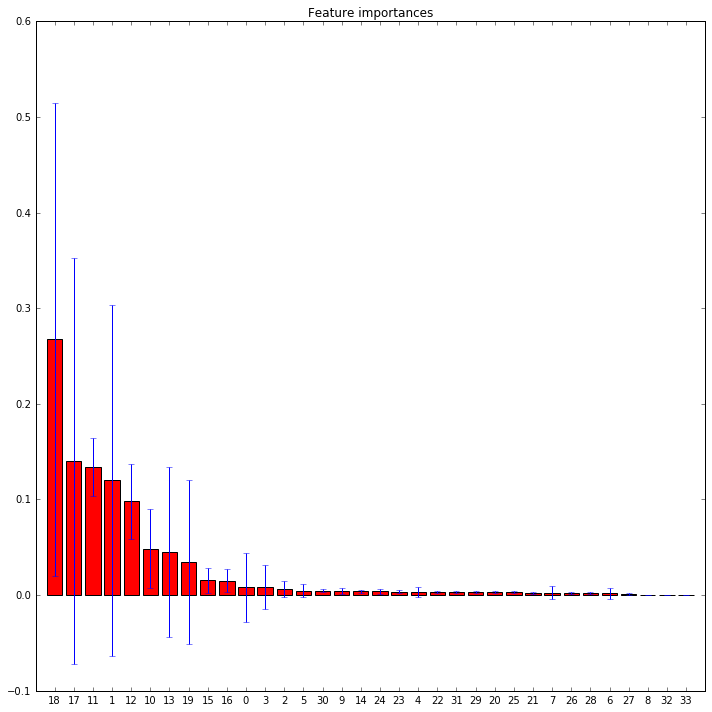

In [462]:
%matplotlib inline
import matplotlib.pyplot as plt
forest = clf

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

names = ['common_unigrams_lens','common_unigrams_ratios','common_bigrams_lens','common_bigrams_ratios',
         'common_trigrams_lens','common_trigrams_ratios','lens1','lens2','dif_len','q1_hash','q2_hash',
         'q1_freq','q2_freq','centroid_distances','min_distances','min_distance_tokens_duplic_removed',
         'max_distance_tokens']+ list(x.columns)
for f in range(X.shape[1]):
    print((f + 1, names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [214]:
clf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features=6, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
Testing_Set = pd.read_csv('test.csv')
print(Testing_Set.shape)
clean_data_test = Testing_Set[['question1','question2']].values


(2345796, 3)


In [ ]:
basic_features = select_basic_features_test(clean_data_test)
new_features_test = test_comb[['q1_hash','q2_hash','q1_freq','q2_freq']].values

In [ ]:
print(basic_features.shape,new_features_test.shape)
X_submission = np.column_stack([basic_features,new_features_test])
X_submission = preprocessing.scale(X_submission)
y_submission = clf.predict_proba(X_submission)[:,1]
Testing_Set['is_duplicate'] = y_submission

In [ ]:
submission = Testing_Set[['test_id','is_duplicate']]

In [ ]:
print(submission)

In [ ]:
submission = submission.to_csv('/Users/pascalsitbon/work/Kaggle/pred.csv',index=False)